# Traffic Sign Recognition (Sliding RandAugment)

In [35]:
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import torch
import random
import numpy as np
from torchvision import models
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import pandas as pd
from tqdm import tqdm
import time
from sklearn.metrics import classification_report
import seaborn as sns
from datetime import datetime
import albumentations as A

### Check GPU availability

In [33]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

PyTorch version: 2.6.0+cu118
CUDA available: True
GPU device name: NVIDIA GeForce RTX 3050 Laptop GPU


### Set random seed for reproducibility (optional)

In [34]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

torch.backends.cudnn.deterministic = True # Ensure deterministic behavior for reproducibility
torch.backends.cudnn.benchmark = False # Disable the benchmark mode to avoid non-deterministic behavior

### Create directories for models and training data

In [ ]:
if not os.path.exists('MODELS'):
    os.makedirs('MODELS')
if not os.path.exists('TrainingGTSRB'):
    os.makedirs('TrainingGTSRB')
if not os.path.exists('TrainingGTSRB_BALANCED'):
    os.makedirs('TrainingGTSRB_BALANCED')
if not os.path.exists('TrainingCIFAR10'):
    os.makedirs('TrainingCIFAR10')
if not os.path.exists('TrainingETSD'):
    os.makedirs('TrainingETSD')
if not os.path.exists('TrainingETSD_BALANCED'):
    os.makedirs('TrainingETSD_BALANCED')
if not os.path.exists('TEST_results.csv'):
    os.makedirs('TEST_results')

## __Dataset__

### _Balancing the dataset_

In [36]:
augmentations = [
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    A.Rotate(limit=10)
]

In [37]:
import shutil

for i in range(2):
    if i == 0:
        dir = 'DATASETS/gtsrb/Train'
        balanced_dir = 'DATASETS/gtsrb/Train_BALANCED'
        new_max_class = round(0.6 * (max([len(os.listdir(dir + '/' + str(i))) for i in range(43)])))
    else:
        dir = 'DATASETS/etsd/Training'
        balanced_dir = 'DATASETS/etsd/Training_BALANCED'
        new_max_class = round(0.3 * (max([len(os.listdir(dir + '/' + str(i).zfill(3))) for i in range(164)])))

    if not os.path.exists(balanced_dir):
        files = os.listdir(dir)
        shutil.copytree(dir, balanced_dir)

    for label_dir in os.listdir(balanced_dir):
        label_path = os.path.join(balanced_dir, label_dir)
        num_files = len(os.listdir(label_path))

        # Reduce gtsrb if too large
        if num_files > new_max_class:
            to_delete = random.sample(os.listdir(label_path), k=num_files - new_max_class)
            for image in to_delete:
                os.remove(os.path.join(label_path, image))

        # Augment gtsrb if too small
        elif num_files < new_max_class:
            images = os.listdir(label_path)
            required = new_max_class - num_files  # How many new images we need
            to_augment = random.choices(images, k=required)  # Prevent duplicates

            for image in to_augment:
                image_path = os.path.join(label_path, image)
                img = Image.open(image_path)
                img_array = np.array(img)

                # Apply random augmentation
                current_augment = random.choice(augmentations)
                augmented = current_augment(image=img_array)['image']
                augmented_image = Image.fromarray(augmented)  # Convert back to PIL image format

                # Save augmented image with a unique name
                new_image_name = f"{os.path.splitext(image)[0]}_A{random.randint(1000, 9999)}.png"
                augmented_image.save(os.path.join(label_path, new_image_name))

### _Visualizing the data_

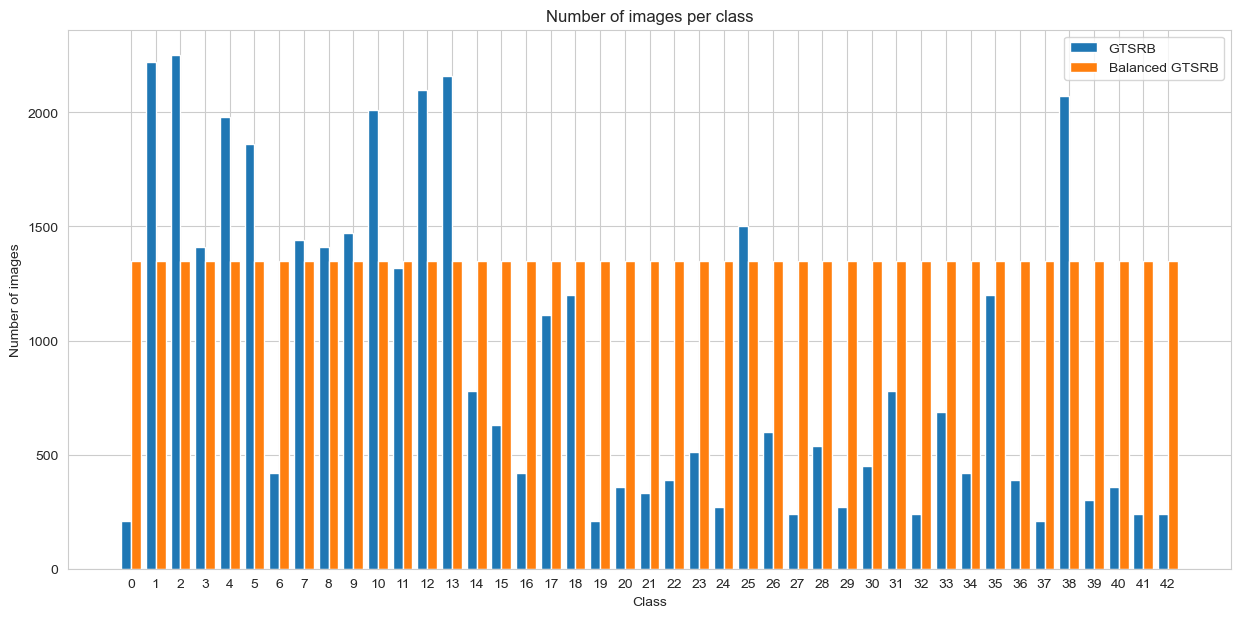

GTSRB: 39209 images
Balanced GTSRB: 58050 images


In [38]:
X = range(0, 43)
gtsrb = [len(os.listdir('DATASETS/gtsrb/Train/' + str(i))) for i in range(43)]
gtsrb_balanced = [len(os.listdir('DATASETS/gtsrb/Train_BALANCED/' + str(i))) for i in range(43)]

X_axis = np.arange(len(X))
plt.figure(figsize=(15, 7))
plt.bar(X_axis - 0.2, gtsrb, 0.4, label='GTSRB')
plt.bar(X_axis + 0.2, gtsrb_balanced, 0.4, label='Balanced GTSRB')

plt.xticks(X_axis, X)
plt.title('Number of images per class')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.legend()
plt.show()

print("GTSRB:", sum(gtsrb), "images")
print("Balanced GTSRB:", sum(gtsrb_balanced), "images")

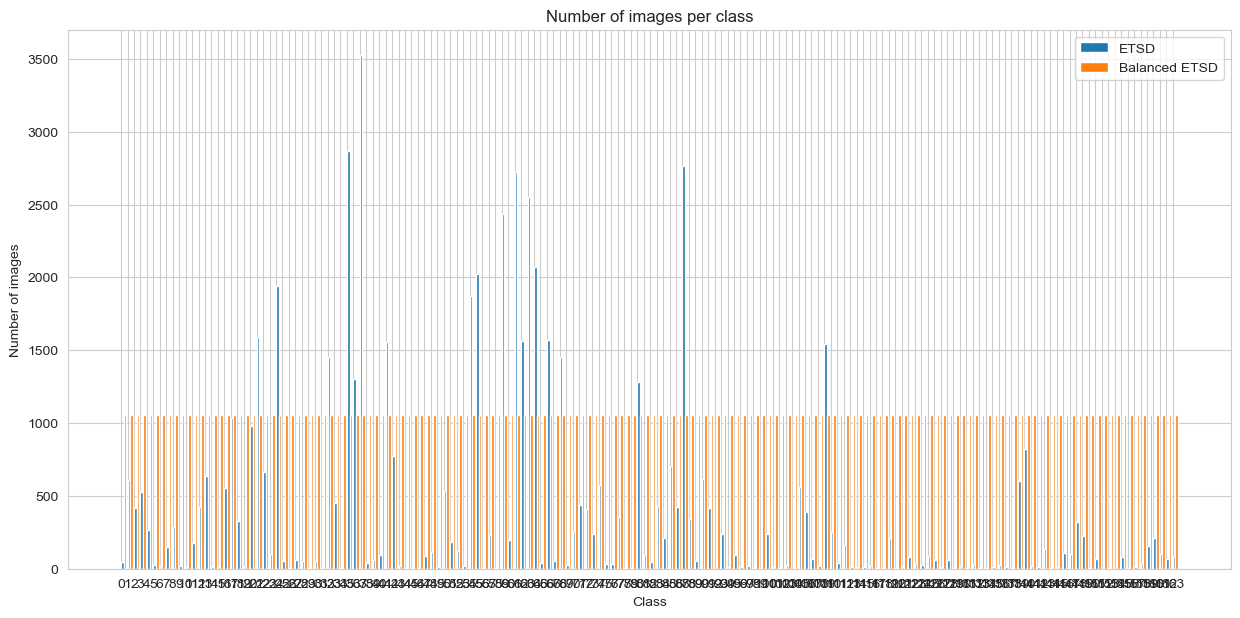

ETSD: 60515 images
Balanced ETSD: 173348 images


In [39]:
X = range(164)
etsd = [len(os.listdir(f'DATASETS/etsd/Training/{str(i).zfill(3)}')) for i in range(164)]
etsd_balanced = [len(os.listdir(f'DATASETS/etsd/Training_BALANCED/{str(i).zfill(3)}')) for i in range(164)]

X_axis = np.arange(len(X))
plt.figure(figsize=(15, 7))
plt.bar(X_axis + 0.2, etsd, 0.4, label='ETSD')
plt.bar(X_axis + 0.6, etsd_balanced, 0.4, label='Balanced ETSD')

plt.xticks(X_axis, X)
plt.title('Number of images per class')
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.legend()
plt.show()

print("ETSD:", sum(etsd), "images")
print("Balanced ETSD:", sum(etsd_balanced), "images")

### _Loading and preprocessing data_

In [40]:
class GTSRB_LOADER(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load all image paths and labels in the gtsrb
        for label_dir in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label_dir)
            for img_file in os.listdir(label_path):
                self.image_paths.append(os.path.join(label_path, img_file))
                self.labels.append(int(label_dir))
    # Returns the number of images in the gtsrb
    def __len__(self):
        return len(self.image_paths)
    # Returns the image and label at the given index
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        with Image.open(img_path) as img:
            image = img.copy()
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [41]:
class Cifar10(Dataset):
    def __init__(self, root_d, transform=None):
        self.root_dir = root_d
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {
            'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
            'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9
        }

        for label_d in os.listdir(root_d):
            label_p = os.path.join(root_d, label_d)
            for img_file in os.listdir(label_p):
                self.image_paths.append(os.path.join(label_p, img_file))
                self.labels.append(self.class_to_idx[label_d])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        with Image.open(img_path) as img:
            image = img.copy()
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [42]:
class ETSD_LOADER(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        for label_dir in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label_dir)
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                with Image.open(img_path) as img:
                    if img.size > (30, 30):
                        self.image_paths.append(img_path)
                        self.labels.append(int(label_dir))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        with Image.open(img_path) as img:
            image = img.copy()
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

#### _Loading the datasets_
##### Comment out the datasets you don't want to use

In [43]:
datasets = []

transform = transforms.Compose([
    transforms.Resize((45, 45)),  # Resize to 45x45
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values to [-1, 1] range
])
transform_cifar = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32x32 (CIFAR-10)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize pixel values to [-1, 1] range
])

# Comment out the datasets you don't want to use

GTSRB = GTSRB_LOADER("DATASETS/gtsrb/Train", transform=transform) #GTSRB
datasets.append(('GTSRB', GTSRB))

GTSRB_BALANCED = GTSRB_LOADER("DATASETS/gtsrb/Train_BALANCED", transform=transform) #GTSRB BALANCED
datasets.append(('GTSRB_BALANCED', GTSRB_BALANCED))

CIFAR10 = Cifar10("DATASETS/cifar10/train", transform=transform_cifar) #CIFAR-10
datasets.append(('CIFAR10', CIFAR10))

ETSD = ETSD_LOADER("DATASETS/etsd/Training", transform=transform) #ETSD
datasets.append(('ETSD', ETSD))

ETSD_BALANCED = ETSD_LOADER("DATASETS/etsd/Training_BALANCED", transform=transform) #ETSD BALANCED
datasets.append(('ETSD_BALANCED', ETSD_BALANCED))

In [44]:
processed_datasets = []

for dataset_n, dataset in datasets:
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_data, batch_size=16, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, drop_last=True)

    processed_datasets.append((dataset_n, train_loader, val_loader))


### _Augmentations_

#### _RandAugment (original)_

In [45]:
def randaugment(img, N, m):
    transforms = [
        A.Equalize(p=1.0),
        A.Rotate(limit=int(min(30, (m / 30) * 30) * random.choice([-1, 1])), p=1.0),
        A.Solarize(threshold=int(max(0, min(255, 256 - (m / 30) * 256))), p=1.0),
        A.ColorJitter(brightness=(1 + (m / 30) * 0.9 * random.choice([-1, 1])), p=1.0),
        A.Posterize(num_bits=int(max(1, min(8, 8 - (m / 30) * 6))), p=1.0),
        A.RandomBrightnessContrast(brightness_limit=(m / 30) * 0.3 * random.choice([-1, 1]), contrast_limit=0, p=1.0),
        A.RandomBrightnessContrast(brightness_limit=0, contrast_limit=(m / 30) * 0.3 * random.choice([-1, 1]), p=1.0),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1), p=1.0),
        A.Affine(shear=(-abs(m / 30) * 20, abs(m / 30) * 20), p=1.0),
        A.Affine(translate_percent=(-abs(m / 30) * 0.3, abs(m / 30) * 0.3), scale=(1 - abs(m / 30) * 0.3, 1 + abs(m / 30) * 0.3), rotate=0, p=1.0),
    ]
    sampled_ops = random.sample(transforms, N)  # Sample N augmentations without replacement

    augmented = A.Compose(sampled_ops)(image=img)
    return augmented['image']


#### _Sliding RandAugment_

In [46]:
simple_transforms = [
    A.RandomBrightnessContrast(brightness_limit=0.05, contrast_limit=0.05, p=1),  # Mild brightness/contrast
    A.Rotate(limit=5, border_mode=cv2.BORDER_REFLECT_101, p=1),  # Small rotation
    A.HueSaturationValue(hue_shift_limit=2, sat_shift_limit=5, p=1),  # Small color shift
    A.ISONoise(intensity=(0.01, 0.1), p=1),  # Mild noise
    A.Affine(translate_percent=0.015, scale=(0.98, 1.02), rotate=0, p=1),  # Slight translation/scale
    A.Sharpen(alpha=(0.05, 0.2), lightness=(0.2, 0.3), p=1),  # Reduced sharpening
    A.RGBShift(r_shift_limit=2, g_shift_limit=2, b_shift_limit=2, p=1),  # Small RGB shift
    A.CLAHE(clip_limit=1.5, tile_grid_size=(6, 6), p=1),  # Mild contrast enhancement
    A.RandomGamma(gamma_limit=(98, 102), p=1),  # Slight gamma adjustment
]

complex_transforms = [
    A.Solarize(threshold=130, p=1),  # Lower contrast solarization
    A.RandomShadow(num_shadows_lower=1, num_shadows_upper=2, shadow_dimension=3, p=1),  # Reduced shadow effect
    A.RandomFog(fog_coef_lower=0.01, fog_coef_upper=0.05, alpha_coef=0.05, p=1),  # Mild fog
    A.OpticalDistortion(distort_limit=0.015, shift_limit=0.02, interpolation=cv2.INTER_LINEAR, p=1),  # Reduced distortion
    A.RandomRain(slant_lower=-3, slant_upper=3, drop_length=6, drop_width=1, blur_value=2, p=1),  # Softer rain effect
    A.MotionBlur(blur_limit=3, p=1),  # Light blur
    A.RandomSnow(snow_point_lower=0.01, snow_point_upper=0.05, brightness_coeff=0.95, p=1),  # Less aggressive snow
    A.Perspective(scale=0.02, p=1),
    A.RandomSunFlare(num_flare_circles_lower=1, num_flare_circles_upper=2, src_radius=3, p=1),  # Softer sun flares
]

In [47]:
def simple_window(window_start, window_end):
    window_augmentations = []
    if window_end == window_start:
        window_augmentations.append(simple_transforms[window_start - 1])
        return window_augmentations
    for i in range(window_start, window_end):
        window_augmentations.append(simple_transforms[i])
    
    return window_augmentations
    
def complex_window(window_start, window_end):
    window_augmentations = []
    if window_end == window_start:
        window_augmentations.append(complex_transforms[0])
        return window_augmentations
    for i in range(window_start, window_end):
        window_augmentations.append(complex_transforms[i])
        
    return window_augmentations

## __Models__

In [49]:
class MobilNetV2(nn.Module):
    def __init__(self, num_classes):
        super(MobilNetV2, self).__init__()
        self.model = models.mobilenet_v2()
        self.model.classifier[1] = nn.Linear(1280, num_classes)

    def forward(self, x):
        return self.model(x)

class SqueezeNet(nn.Module):
    def __init__(self, num_classes):
        super(SqueezeNet, self).__init__()
        self.model = models.squeezenet1_0()
        self.model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        return self.model(x)

In [50]:
import math

"""
Wide ResNet by Sergey Zagoruyko and Nikos Komodakis
Fixup initialization by Hongyi Zhang, Yann N. Dauphin, Tengyu Ma
Based on code by xternalz and Andy Brock:
https://github.com/xternalz/WideResNet-pytorch
https://github.com/ajbrock/BoilerPlate
"""


class BasicBlock(nn.Module):
    droprate = 0.0
    use_bn = True
    use_fixup = False
    fixup_l = 12

    def __init__(self, in_planes, out_planes, stride):
        super(BasicBlock, self).__init__()

        self.bn1 = nn.BatchNorm2d(in_planes)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.equalInOut = in_planes == out_planes
        self.conv_res = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, padding=0, bias=False)
        self.conv_res = not self.equalInOut and self.conv_res or None

        assert self.use_fixup or self.use_bn, "Need to use at least one thing: Fixup or BatchNorm"

        if self.use_fixup:
            self.multiplicator = nn.Parameter(torch.ones(1,1,1,1))
            self.biases = nn.ParameterList([nn.Parameter(torch.zeros(1,1,1,1))] * 4)

            k = self.conv1.kernel_size[0] * self.conv1.kernel_size[1] * self.conv1.out_channels
            self.conv1.weight.data.normal_(0, self.fixup_l ** (-0.5) * math.sqrt(2. / k))
            self.conv2.weight.data.zero_()

            if self.conv_res is not None:
                k = self.conv_res.kernel_size[0] * self.conv_res.kernel_size[1] * self.conv_res.out_channels
                self.conv_res.weight.data.normal_(0, math.sqrt(2. / k))

    def forward(self, x):
        if self.use_bn:
            x_out = self.relu(self.bn1(x))
            out = self.relu(self.bn2(self.conv1(x_out)))
            if self.droprate > 0:
                out = F.dropout(out, p=self.droprate, training=self.training)
            out = self.conv2(out)
        else:
            x_out = self.relu(x + self.biases[0])
            out = self.conv1(x_out) + self.biases[1]
            out = self.relu(out) + self.biases[2]
            if self.droprate > 0:
                out = F.dropout(out, p=self.droprate, training=self.training)
            out = self.multiplicator * self.conv2(out) + self.biases[3]

        if self.equalInOut:
            return torch.add(x, out)

        return torch.add(self.conv_res(x_out), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride):
        layers = []

        for i in range(int(nb_layers)):
            _in_planes = i == 0 and in_planes or out_planes
            _stride = i == 0 and stride or 1
            layers.append(block(_in_planes, out_planes, _stride))

        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

#@registry.Model
class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, droprate=0.0, use_bn=True, use_fixup=False):
        super(WideResNet, self).__init__()

        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]

        assert (depth - 4) % 6 == 0, "You need to change the number of layers"
        n = (depth - 4) / 6

        BasicBlock.droprate = droprate
        BasicBlock.use_bn = use_bn
        BasicBlock.fixup_l = n * 3
        BasicBlock.use_fixup = use_fixup
        block = BasicBlock

        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1, padding=1, bias=False)

        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2)

        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                k = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / k))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
                if use_fixup:
                    m.weight.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [51]:
import torch.nn as nn
class DeepThin(nn.Module):
    def __init__(self, num_classes, img_size):
        super(DeepThin, self).__init__()
        # BatchNorm for input image
        self.img_size = img_size
        self.input_bn = nn.BatchNorm2d(3)  # Normalize input image (3 channels for RGB)

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Overlapping MaxPooling layer after conv2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)

        # Third convolutional block
        self.conv3 = nn.Conv2d(32, 48, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(48)

        # Fourth convolutional block
        self.conv4 = nn.Conv2d(48, 48, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(48)

        # Overlapping MaxPooling layer after conv4
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)

        # Calculate the size of the input to the first fully connected layer
        self._to_linear = None
        self.convs(torch.randn(1, 3, img_size, img_size))  # Dummy forward pass to calculate the size

        # Flatten and fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)  # Batch Norm after first FC
        self.drop = nn.Dropout(p=0.5)  # Dropout layer
        self.fc2 = nn.Linear(512, num_classes)

    def convs(self, x):
        x = self.input_bn(x)                # BatchNorm on input image
        x = F.relu(self.bn1(self.conv1(x)))  # Conv1 -> BatchNorm -> ReLU
        x = F.relu(self.bn2(self.conv2(x)))  # Conv2 -> BatchNorm -> ReLU
        x = self.pool1(x)                   # Overlapping Max Pooling
        x = F.relu(self.bn3(self.conv3(x)))  # Conv3 -> BatchNorm -> ReLU
        x = F.relu(self.bn4(self.conv4(x)))  # Conv4 -> BatchNorm -> ReLU
        x = self.pool2(x)                   # Overlapping Max Pooling

        if self._to_linear is None:
            self._to_linear = x[0].numel()
        return x

    def forward(self, x):
        x = self.convs(x)
        x = torch.flatten(x, 1)             # Flatten all dimensions except batch
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.drop(x)                    # Dropout
        x = self.fc2(x)
        return F.softmax(x, dim=1)      # Softmax for classification output


#### Comment out the models you don't want to use

In [52]:
MYmodels = []

MYmodels.append('DeepThin')
MYmodels.append('MobilNetV2')
MYmodels.append('SqueezeNet')
MYmodels.append('WideResNet')

## __Training__

In [53]:
def apply_sliding_randaugment(img_np, transform_T):
    img_np = (img_np * 255).astype(np.uint8)
    aug = A.Compose(transform_T)(image=img_np)['image']
    aug_img = torch.from_numpy(aug).float() / 255
    aug_img = aug_img.permute(2, 0, 1)
    return aug_img

In [54]:
def apply_original_randaugment(img_np, N, M):
    img_np = (img_np * 255).astype(np.uint8)
    augmented_images = randaugment(img_np, N, M)
    aug_img = torch.from_numpy(augmented_images).float() / 255
    aug_img = aug_img.permute(2, 0, 1)
    return aug_img

In [55]:
def apply_transforms(images, labels, orig_Randaugment, sliding_Randaugment, transform_T):
    augmented_images = []
    augmented_labels = []
    std = torch.tensor([0.5, 0.5, 0.5])
    mean = torch.tensor([0.5, 0.5, 0.5])

    for i in range(images.size(0)):
        denormalized_tensor = images[i] * std[:, None, None] + mean[:, None, None]
        img_np = denormalized_tensor.permute(1, 2, 0).cpu().numpy()

        if orig_Randaugment:
            aug_img = apply_original_randaugment(img_np, 2, 1)
            augmented_images.append(aug_img)
            augmented_labels.append(labels[i])

        elif sliding_Randaugment:
            aug_img = apply_sliding_randaugment(img_np, transform_T)
            augmented_images.append(aug_img)
            augmented_labels.append(labels[i])

    augmented_images = torch.stack(augmented_images)
    augmented_labels = torch.stack(augmented_labels)

    all_i = torch.cat((images, augmented_images), dim=0)
    all_l = torch.cat((labels, augmented_labels), dim=0)

    indices = torch.randperm(all_i.size(0))
    all_i = all_i[indices]
    all_l = all_l[indices]

    return all_i, all_l

### _Training the model_

#### Set number of epochs, training parameters, windows sizes and comment out the condition if you want to use only one method

In [57]:
# Change these settings if needed. These setting were used for the paper
num_epochs = 17

simple_window_size = 3
complex_window_size = 2

applied_simple_transforms = 2
applied_complex_transforms = 1

orig_Randaugment = False
sliding_Randaugment = False # True if you only want to use sliding RandAugment, then set range below to one and comment out the conditions at the beginning of the loop

#----------------------------------------------------------
trained_models = []
applied_transforms = []

num_of_SIM_augmentations = len(simple_transforms)
num_of_COM_augmentations = len(complex_transforms)

simple_slide = max(1, round(((num_epochs // 3) * 2) / (num_of_SIM_augmentations - simple_window_size)))
complex_slide = max(1, round((num_epochs // 3) / (num_of_COM_augmentations - complex_window_size)))

for i in tqdm(range(3)):
    # Comment out the conditions below if you want to use only one method or two methods
    if i == 0:
        orig_Randaugment = False
        sliding_Randaugment = False
    elif i == 1:
        orig_Randaugment = True
        sliding_Randaugment = False
    else:
        orig_Randaugment = False
        sliding_Randaugment = True
    #----------------------------------------------------------
    for model_name in MYmodels:
        for dataset_name, train_loader, val_loader in processed_datasets:
            if dataset_name == 'CIFAR10':
                num_classes = 10
                img_size = 32
            elif dataset_name == 'ETSD' or dataset_name == 'ETSD_BALANCED':
                num_classes = 164
                img_size = 45
            else:
                num_classes = 43
                img_size = 45

            if model_name == 'MobilNetV2':
                model = MobilNetV2(num_classes)
            elif model_name == 'SqueezeNet':
                model = SqueezeNet(num_classes)
            elif model_name == 'WideResNet':
                model = WideResNet(depth=28, num_classes=num_classes, widen_factor=10, droprate=0.3, use_bn=True, use_fixup=True)
            else:
                model = DeepThin(num_classes, img_size)

            model.to(device)

            loss_fn = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

            s_window_start = 0 # Start index for simple augmentations
            c_window_start = 0 # Start index for complex augmentations

            epoch_times = [] # Store epoch times

            transform_T = [] # Store transformations for Sliding RandAugment
            stats = [] # Store training statistics for each epoch
            train_losses, val_losses = [], [] # Store training and validation losses
            train_accuracies, val_accuracies = [], [] # Store training and validation accuracies

            simple = False
            augmentation_type = None

            for epoch in range(num_epochs):
                time_start = time.time()
                if sliding_Randaugment:
                    if epoch < num_epochs // 3 or epoch >= 2 * num_epochs // 3 + 1:
                        simple = True
                        s_window_end = min(s_window_start + simple_window_size, num_of_SIM_augmentations)
                        simple_aug = simple_window(s_window_start, s_window_end)
                        transform_T = random.sample(simple_aug, min(applied_simple_transforms, len(simple_aug)))
                        s_window_start = [s_window_start + 1 if epoch % simple_slide == 0 else s_window_start][0]
                    else:
                        simple = False
                        c_window_end = min(c_window_start + complex_window_size, num_of_COM_augmentations)
                        complex_aug = complex_window(c_window_start, c_window_end)
                        transform_T = random.sample(complex_aug, min(applied_complex_transforms, len(complex_aug)))
                        c_window_start = [c_window_start + 1 if epoch % complex_slide == 0 else c_window_start][0]

                model.train()
                train_loss = 0
                train_correct = 0
                train_total = 0
                all_preds = []
                all_labels = []

                for images, labels in train_loader:
                    if orig_Randaugment or sliding_Randaugment:
                        if sliding_Randaugment:
                            augmentation_type = "Simple" if simple else "Complex"
                        images, labels = apply_transforms(images, labels, orig_Randaugment, sliding_Randaugment, transform_T)

                    labels = labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(images.to(device))
                    loss = loss_fn(outputs, labels)

                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    train_total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()

                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                precision, recall, f1, _ = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)['weighted avg'].values()

                train_accuracy = 100 * train_correct / train_total
                train_accuracies.append(train_accuracy)

                val_loss = 0
                val_correct = 0
                val_total = 0
                val_preds = []
                val_labels_list = []

                model.eval()
                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        loss = loss_fn(outputs, labels)

                        val_loss += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        val_total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()

                        val_preds.extend(predicted.cpu().numpy())
                        val_labels_list.extend(labels.cpu().numpy())

                val_precision, val_recall, val_f1, _ = classification_report(val_labels_list, val_preds, output_dict=True, zero_division=0)['weighted avg'].values()

                val_accuracy = 100 * val_correct / val_total
                val_accuracies.append(val_accuracy)

                scheduler.step()

                time_stop = time.time() - time_start

                train_losses.append(train_loss / len(train_loader))
                val_losses.append(val_loss / len(val_loader))

                stats.append([
                    epoch + 1, f"{train_loss:.4f}", f"{val_loss:.4f}",
                    f"{train_accuracies[-1]:.2f}%", f"{val_accuracies[-1]:.2f}%",
                    f"{precision:.4f}", f"{recall:.4f}", f"{f1:.4f}",
                    f"{val_precision:.4f}", f"{val_recall:.4f}", f"{val_f1:.4f}",
                    f"{time_stop:.2f}s", f"{augmentation_type}"
                ])

            columns = ["Epoch", "Train Loss", "Val Loss", "Train Acc", "Val Acc",
                       "Precision", "Recall", "F1", "Val Precision", "Val Recall", "Val F1",
                       "Epoch Time", "Augmentation"]


            df = pd.DataFrame(stats, columns=columns)

            if orig_Randaugment:
                augmentation_method = "RandAugment"
            elif sliding_Randaugment:
                augmentation_method = "Sliding RandAugment"
            else:
                augmentation_method = "Not selected"

            if dataset_name == 'GTSRB':
                df.to_csv(f"TrainingGTSRB/Training_{model_name}_{augmentation_method}_{dataset_name}.csv", index=False)
            elif dataset_name == 'GTSRB_BALANCED':
                df.to_csv(f"TrainingGTSRB_BALANCED/Training_{model_name}_{augmentation_method}_{dataset_name}.csv", index=False)
            elif dataset_name == 'CIFAR10':
                df.to_csv(f"TrainingCIFAR/Training_{model_name}_{augmentation_method}_{dataset_name}.csv", index=False)
            elif dataset_name == 'ETSD':
                df.to_csv(f"TrainingETSD/Training_{model_name}_{augmentation_method}_{dataset_name}.csv", index=False)
            elif dataset_name == 'ETSD_BALANCED':
                df.to_csv(f"TrainingETSD_BALANCED/Training_{model_name}_{augmentation_method}_{dataset_name}.csv", index=False)

            sns.set_style("whitegrid")

            timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
            save_dir_loss = "Training_plots_Loss"
            save_dir_acc = "Training_plots_Accuracy"
            os.makedirs(save_dir_loss, exist_ok=True)
            os.makedirs(save_dir_acc, exist_ok=True)

            plt.figure(figsize=(8, 5))
            plt.plot(train_losses, marker='o', linestyle='-', label="Training Loss", color="blue")
            plt.plot(val_losses, marker='s', linestyle='--', label="Validation Loss", color="red")
            plt.title(f"Loss vs Epochs\n{model_name} - {augmentation_method} ({dataset_name})")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.savefig(f"{save_dir_loss}/Loss_{model_name}_{augmentation_method}_{dataset_name}_{timestamp}.png")  # Save unique file
            plt.close()

            plt.figure(figsize=(8, 5))
            plt.plot(train_accuracies, marker='o', linestyle='-', label="Training Accuracy", color="blue")
            plt.plot(val_accuracies, marker='s', linestyle='--', label="Validation Accuracy", color="red")
            plt.title(f"Accuracy vs Epochs\n{model_name} - {augmentation_method} ({dataset_name})")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy (%)")
            plt.legend()
            plt.savefig(f"{save_dir_acc}/Accuracy_{model_name}_{augmentation_method}_{dataset_name}_{timestamp}.png")  # Save unique file
            plt.close()


            torch.save(model, f"MODELS/{model_name}_{augmentation_method}_{dataset_name}.pth")


100%|██████████| 3/3 [22:55<00:00, 458.56s/it]


## __Testing__

In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import csv

misclassified = []

for model in tqdm(os.listdir('MODELS')):
    model_name = model.split('_')[0] # Get model name from filename
    augmentation_method = model.split('_')[1] # Get augmentation method from filename
    dataset_name = '_'.join(model.split('_')[2:]).replace('.pth', '')
    model_path = f"MODELS/{model}"

    if dataset_name == 'CIFAR10':
        classes = 10
        img_size = 32
    elif dataset_name == 'ETSD':
        classes = 164
        img_size = 45
    else:
        classes = 43
        img_size = 45

    model = torch.load(model_path, weights_only=False)

    if dataset_name == 'GTSRB' or dataset_name == 'GTSRB_BALANCED':
        GD = True
        csv_path = 'DATASETS/gtsrb/Test.csv'
        df = pd.read_csv(csv_path)

        actual_labels = {row['Path'].split('/')[-1]: row['ClassId'] for _, row in df.iterrows()}
        model.eval()

        test_path = 'DATASETS/gtsrb/Test'
        test_images = os.listdir(test_path)

        all_preds = []
        all_labels = []

        for img_name in test_images:
            image = Image.open(os.path.join(test_path, img_name))
            image_tensor = transform(image).unsqueeze(0).to(device)

            with torch.no_grad():
                pred = model(image_tensor).argmax(dim=1).item()

            actual_class = actual_labels[img_name]
            if pred != actual_class:
                misclassified.append((img_name, pred, actual_class))

            all_preds.append(pred)
            all_labels.append(actual_class)

        accuracy = accuracy_score(all_labels, all_preds) * 100
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0) * 100
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0) * 100
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0) * 100

        with open('TEST_results.csv', 'a', newline='\n') as file:
            writer = csv.writer(file)
            writer.writerow([model_name, round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1, 2), augmentation_method, dataset_name, time.strftime("%Y-%m-%d %H:%M:%S")])

    elif dataset_name == 'ETSD' or dataset_name == 'ETSD_BALANCED':

        model.eval()

        test_path = 'DATASETS/etsd/Testing'
        test_images = os.listdir(test_path)

        all_preds = []
        all_labels = []

        for label in os.listdir(test_path):
            label_pa = os.path.join(test_path, label)
            for img_name in os.listdir(label_pa):
                image = Image.open(os.path.join(label_pa, img_name))
                image_tensor = transform(image).unsqueeze(0).to(device)

                with torch.no_grad():
                    pred = model(image_tensor).argmax(dim=1).item()

                all_preds.append(pred)
                all_labels.append(int(label))

        accuracy = accuracy_score(all_labels, all_preds) * 100
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0) * 100
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0) * 100
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0) * 100

        with open('TEST_results.csv', 'a', newline='\n') as file:
            writer = csv.writer(file)
            writer.writerow([model_name, round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1, 2), augmentation_method, dataset_name, time.strftime("%Y-%m-%d %H:%M:%S")])

    elif dataset_name == 'CIFAR10':
        labels = {
            'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
            'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9
        }
        GD = False
        model.eval()
        test_path = 'DATASETS/cifar10/test'
        all_preds = []
        all_labels = []

        for label in os.listdir(test_path):
            label_pa = os.path.join(test_path, label)
            for img_name in os.listdir(label_pa):
                image = Image.open(os.path.join(label_pa, img_name))
                image_tensor = transform_cifar(image).unsqueeze(0).to(device)

                with torch.no_grad():
                    pred = model(image_tensor).argmax(dim=1).item()

                actual_class = labels[label]

                all_preds.append(pred)
                all_labels.append(actual_class)

        accuracy = accuracy_score(all_labels, all_preds) * 100
        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0) * 100
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0) * 100
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0) * 100

        with open('TEST_results.csv', 'a', newline='\n') as file:
            writer = csv.writer(file)
            writer.writerow([model_name, round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1, 2), augmentation_method, dataset_name, time.strftime("%Y-%m-%d %H:%M:%S")])

100%|██████████| 3/3 [03:06<00:00, 62.14s/it]
